# 3D medical image segmentation with one slice annotation

This notebook shows how to use SAM 2 for interactive segmentation in 3D images. It will cover the following:

- propagating a mask to get _masklets_ throughout the video

In [1]:
# Cell 1
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Cell 2
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

### Loading the SAM 2 video predictor

In [3]:
# Cell 3
import os
 
new_dir = "/scratch/mtc5693/SAM_2_Medical_3D"

os.chdir(new_dir)

In [4]:
# Cell 4
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "./checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint)

In [5]:
# Cell 5 (Updated)
def show_mask(mask, ax, obj_id=None, color=None, random_color=False):
    """
    Overlays a colored mask on the provided axis.
    
    Parameters:
      mask: numpy array mask.
      ax: matplotlib axis to overlay the mask.
      obj_id: (optional) object ID to select a default color from tab10.
      color: (optional) a specific color as an array-like of 3 elements (RGB). Alpha will be set to 0.6.
      random_color: if True, generates a random color.
    """
    if random_color:
        # Generate a random color with alpha = 0.6.
        color = np.hstack((np.random.random(3), [0.6]))
    elif color is not None:
        # If a color is provided, ensure it has 4 components (add alpha if needed)
        color = np.array(color)
        if color.size == 3:
            color = np.hstack((color, [0.6]))
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else (obj_id % 10)
        color = np.array(list(cmap(cmap_idx)[:3]) + [0.6])
    
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

len of frames:  128


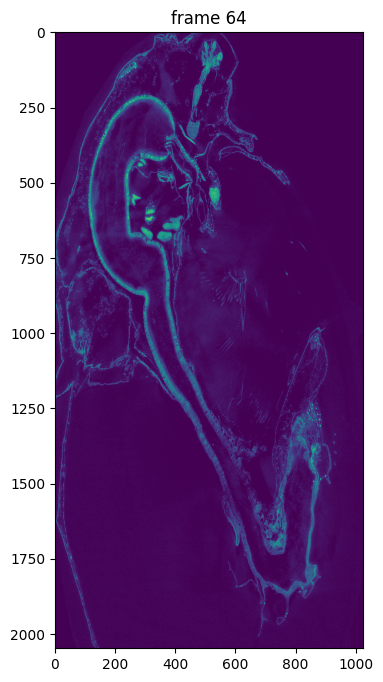

In [6]:
# Cell 6


# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./notebooks/videos/our_data/aaa392_bin0_down" 
ann_obj_id = 1
# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))
print("len of frames: ", len(frame_names))
# take a look the first video frame
frame_idx = len(frame_names) // 2
plt.figure(figsize=(12, 8))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

#### Initialize the inference state

load one mask

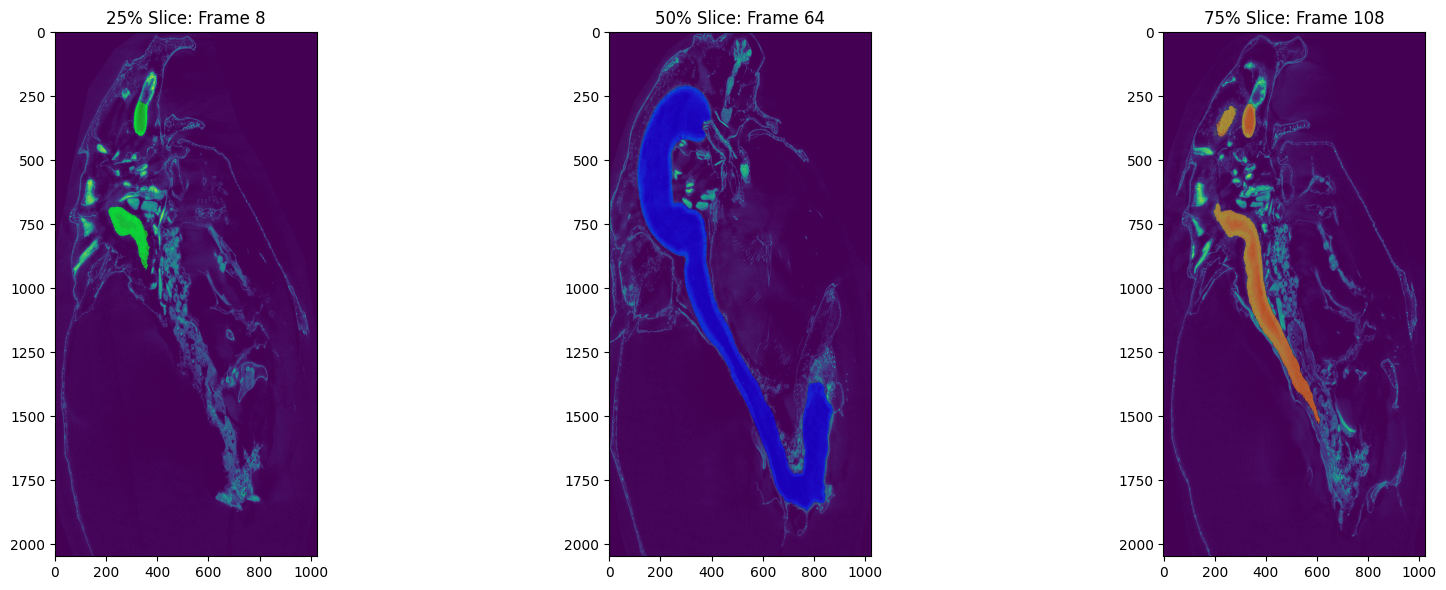

In [7]:
# Cell 7
# Now we select three central slices: 25%, 50%, and 75% of the total frames.
total_frames = len(frame_names)
slice_25 = 8# 25% position
slice_50 = 64   # 50% position (central slice)
slice_75 = 108 # 75% position

mask1 = np.load(os.path.join(video_dir, frame_names[slice_25].replace(".jpg", ".npy")))
mask2 = np.load(os.path.join(video_dir, frame_names[slice_50].replace(".jpg", ".npy")))
mask3 = np.load(os.path.join(video_dir, frame_names[slice_75].replace(".jpg", ".npy")))

# (Optional) Visualize the three annotated slices:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title(f"25% Slice: Frame {slice_25}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[slice_25])))
show_mask(mask1, plt.gca(), color=np.array([0.0, 1.0, 0.0]))  # green

plt.subplot(1, 3, 2)
plt.title(f"50% Slice: Frame {slice_50}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[slice_50])))
show_mask(mask2, plt.gca(), color=np.array([0.0, 0.0, 1.0]))  # blue

plt.subplot(1, 3, 3)
plt.title(f"75% Slice: Frame {slice_75}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[slice_75])))
show_mask(mask3, plt.gca(), color=np.array([1.0, 0.5, 0.0]))  # orange (or any color you like)
plt.tight_layout()
plt.show()


SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).
#### Propagate the prompts to get the masklet across the video

In [8]:
# Cell A: Propagate forward from central slice (slice_50) until slice_75 using central prompt.
inference_state_central_forward = predictor.init_state(video_path=video_dir)
predictor.reset_state(inference_state_central_forward)
predictor.add_new_mask(inference_state=inference_state_central_forward, frame_idx=slice_50, obj_id=2, mask=mask2 > 0.0)
central_forward_segments = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state_central_forward):
    if out_frame_idx > slice_75:
        break
    central_forward_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }


frame loading (JPEG):   5%|▍         | 6/128 [00:00<00:04, 25.15it/s]

propagate in video:  70%|███████   | 45/64 [00:02<00:01, 16.76it/s]


In [9]:
# Cell B: Propagate forward from slice_75 until the end using the 75% prompt.
inference_state_75_forward = predictor.init_state(video_path=video_dir)
predictor.reset_state(inference_state_75_forward)
predictor.add_new_mask(inference_state=inference_state_75_forward, frame_idx=slice_75, obj_id=3, mask=mask3 > 0.0)
forward_75_segments = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state_75_forward):
    if out_frame_idx < slice_75:
        continue
    forward_75_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }


frame loading (JPEG):   0%|          | 0/128 [00:00<?, ?it/s]

propagate in video: 100%|██████████| 20/20 [00:00<00:00, 25.59it/s]


In [10]:
# Cell C: Propagate backward from central slice (slice_50) until slice_25 using the central prompt.
inference_state_central_backward = predictor.init_state(video_path=video_dir)
predictor.reset_state(inference_state_central_backward)
predictor.add_new_mask(inference_state=inference_state_central_backward, frame_idx=slice_50, obj_id=2, mask=mask2 > 0.0)
central_backward_segments = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state_central_backward, start_frame_idx=slice_50, reverse=True):
    if out_frame_idx < slice_25:
        break
    central_backward_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }


propagate in video:  88%|████████▊ | 57/65 [00:02<00:00, 23.94it/s]


In [11]:
# Cell D: Propagate backward from slice_25 until frame 0 using the 25% prompt.
inference_state_25_backward = predictor.init_state(video_path=video_dir)
predictor.reset_state(inference_state_25_backward)
predictor.add_new_mask(inference_state=inference_state_25_backward, frame_idx=slice_25, obj_id=1, mask=mask1 > 0.0)
backward_25_segments = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state_25_backward, start_frame_idx=slice_25, reverse=True):
    # Assuming frame indices decrease and eventually reach 0.
    backward_25_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }


frame loading (JPEG):   0%|          | 0/128 [00:00<?, ?it/s]

propagate in video: 100%|██████████| 9/9 [00:00<00:00, 27.95it/s]


In [12]:
# Cell E (Updated: Combine segmentation results from all propagation segments
# and preserve the manually provided masks at prompt slices)
def union_masks(mask_dict):
    """
    Given a dictionary mapping from object IDs to mask arrays,
    compute the pixel-wise union (logical OR) of all masks.
    Returns a binary numpy array.
    """
    masks = list(mask_dict.values())
    if not masks:
        return None
    union = np.zeros_like(masks[0], dtype=np.uint8)
    for m in masks:
        union = np.logical_or(union, m.astype(bool)).astype(np.uint8)
    return union

full_video_segments = {}

# List all segmentation segments from the propagation cells.
# These segments are defined in earlier cells:
#   backward_25_segments, central_backward_segments, central_forward_segments, forward_75_segments
segments = [backward_25_segments, central_backward_segments, central_forward_segments, forward_75_segments]

for seg in segments:
    for frame, mask_dict in seg.items():
        current_union = union_masks(mask_dict)
        if current_union is None:
            continue
        if frame in full_video_segments:
            # Combine by taking the union (logical OR) of existing and current masks.
            full_video_segments[frame] = np.logical_or(full_video_segments[frame].astype(bool), 
                                                         current_union.astype(bool)).astype(np.uint8)
        else:
            full_video_segments[frame] = current_union

# Ensure that all combined masks are binary (0 or 1)
for frame in full_video_segments:
    full_video_segments[frame] = np.clip(full_video_segments[frame], 0, 1)

# Now, override the predicted masks at the prompt slices with the provided masks.
# This ensures that the manually provided mask remains unchanged.
full_video_segments[slice_25] = mask1
full_video_segments[slice_50] = mask2
full_video_segments[slice_75] = mask3


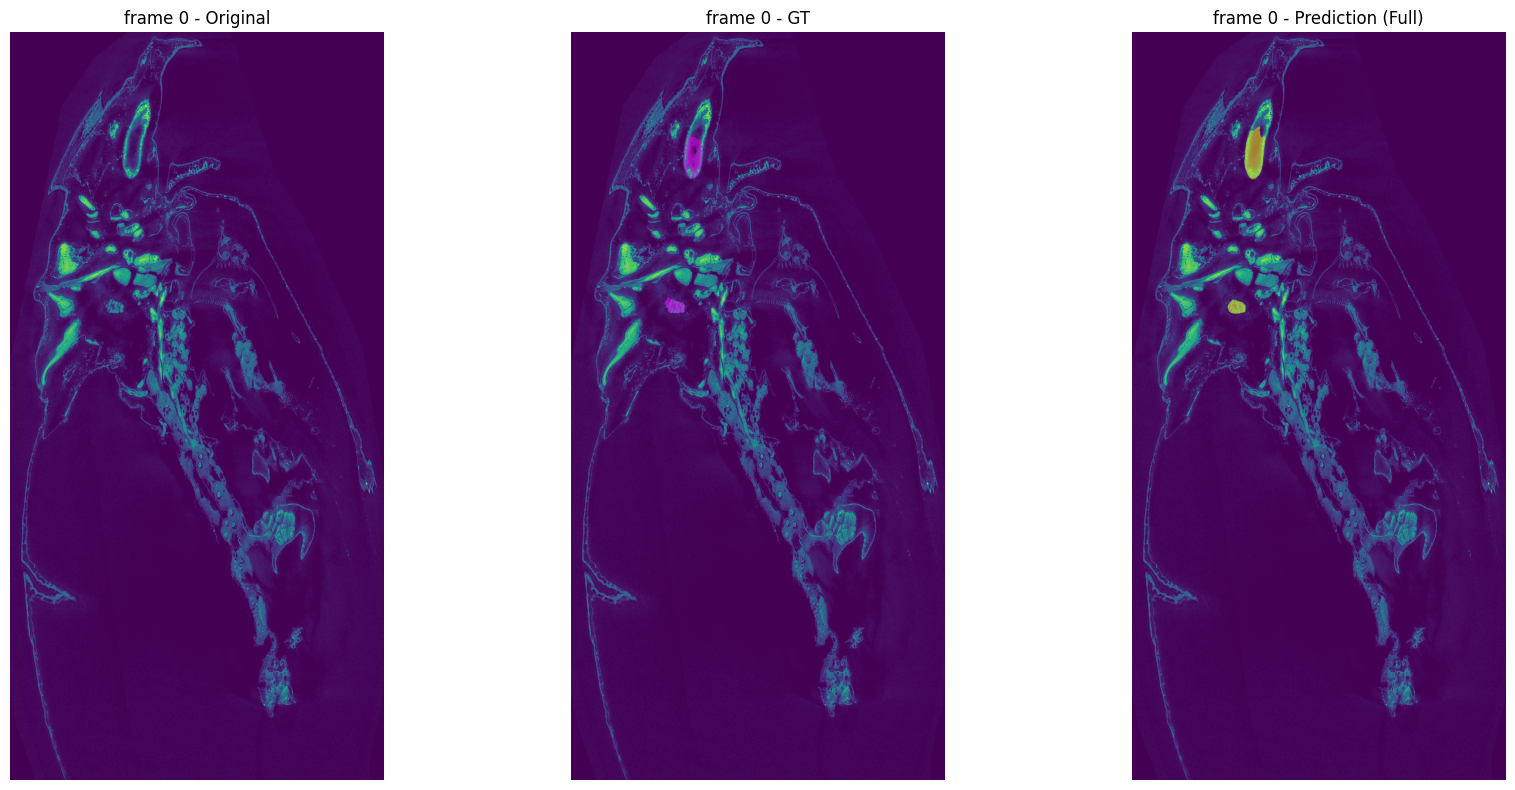

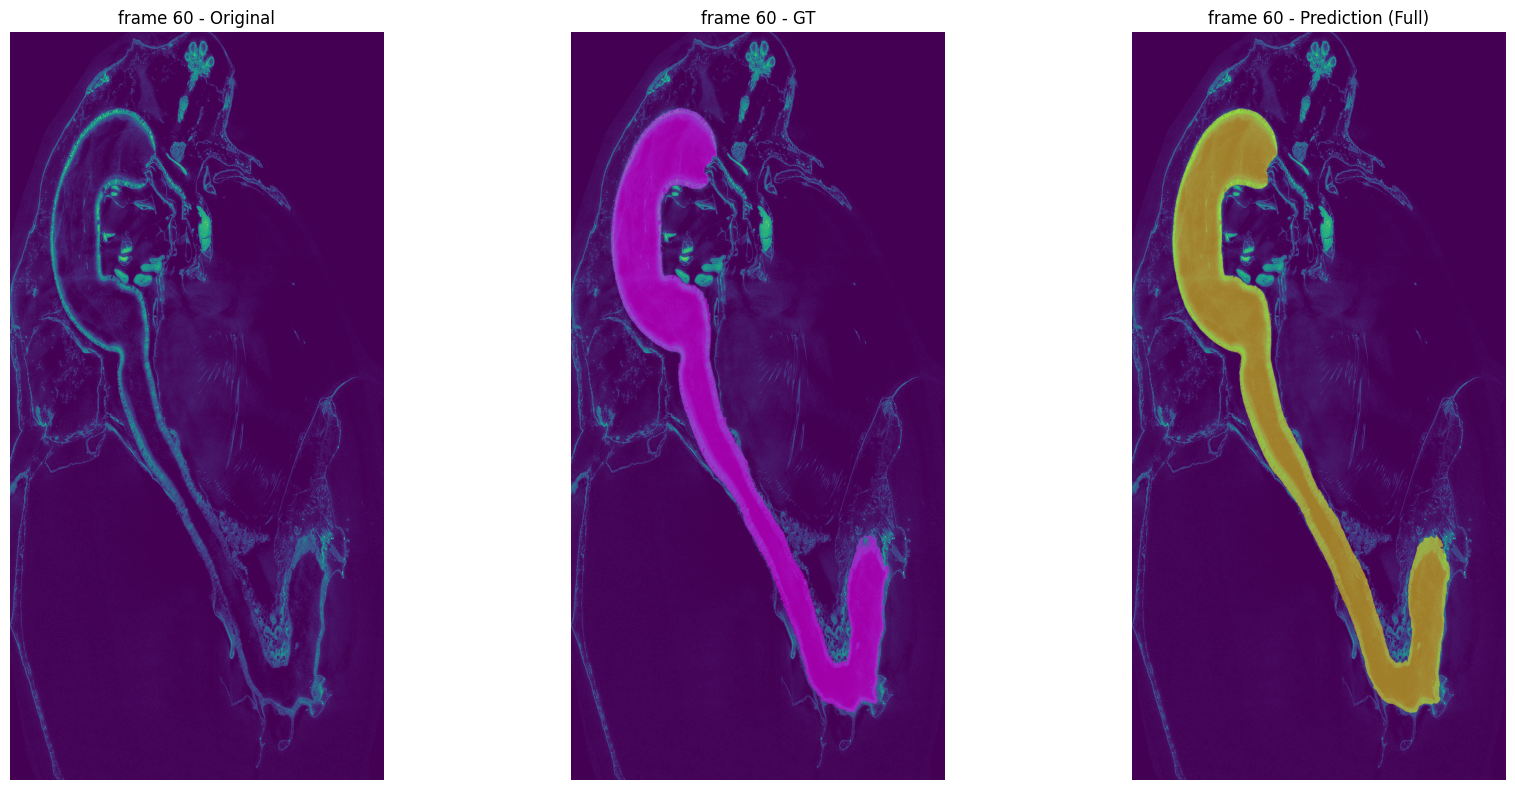

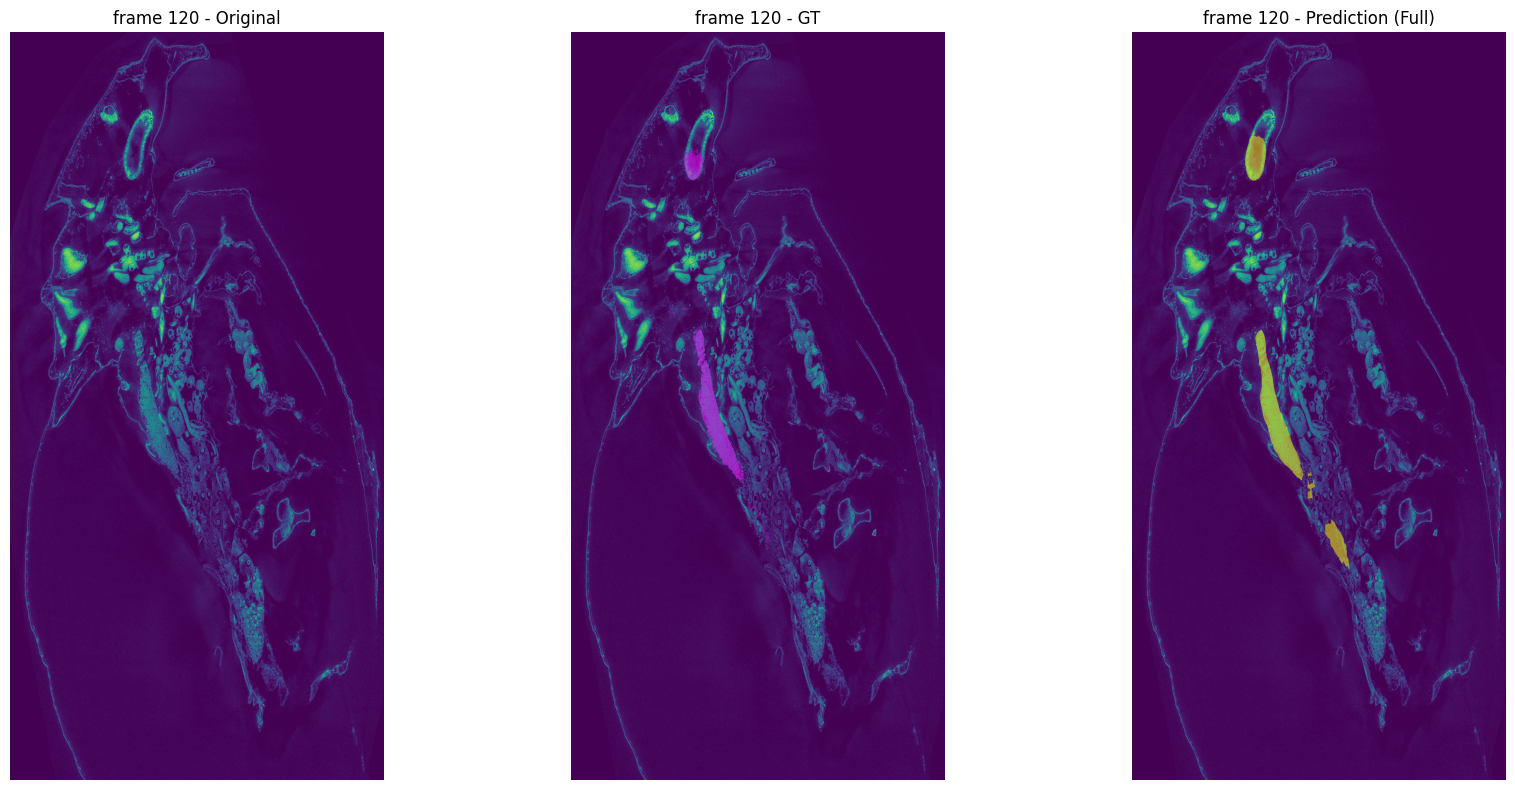

In [13]:
# Cell 12 (Updated: Visualization using full segmentation)
def safe_prepare_mask(mask, target_size):
    mask = np.squeeze(mask)
    mask = mask.astype(np.uint8)
    min_size = 4  # Safe minimum size for PIL
    h, w = mask.shape
    pad_h = max(0, min_size - h)
    pad_w = max(0, min_size - w)
    if pad_h > 0 or pad_w > 0:
        mask = np.pad(mask, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)
    mask_resized = np.array(Image.fromarray(mask).resize(target_size, resample=Image.NEAREST))
    return mask_resized

def show_mask_vis(mask, ax, color=None, alpha=0.5):
    if color is None:
        color = np.array([1.0, 0.0, 0.0])
    mask = np.squeeze(mask).astype(float)
    mask_image = np.zeros((*mask.shape, 4))
    mask_image[..., :3] = color
    mask_image[..., 3] = mask * alpha
    ax.imshow(mask_image)

vis_frame_stride = 60
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    fig, axes = plt.subplots(1, 3, figsize=(18, 8))
    # Original image.
    original_image = Image.open(os.path.join(video_dir, frame_names[out_frame_idx]))
    original_size = original_image.size  # (width, height)
    axes[0].set_title(f"frame {out_frame_idx} - Original")
    axes[0].imshow(original_image)
    axes[0].axis('off')
    # Ground Truth (display saved mask).
    axes[1].set_title(f"frame {out_frame_idx} - GT")
    axes[1].imshow(original_image)
    axes[1].axis('off')
    out_mask_logits_gt = np.load(os.path.join(video_dir, frame_names[out_frame_idx].replace(".jpg", ".npy")))
    out_mask_resized = safe_prepare_mask(out_mask_logits_gt, original_size)
    show_mask_vis(out_mask_resized, axes[1], color=np.array([1.0, 0.0, 1.0]))  # Pink for GT
    # Prediction: show full combined segmentation.
    axes[2].set_title(f"frame {out_frame_idx} - Prediction (Full)")
    axes[2].imshow(original_image)
    axes[2].axis('off')
    if full_video_segments.get(out_frame_idx) is not None:
        out_mask_resized = safe_prepare_mask(full_video_segments[out_frame_idx], original_size)
        show_mask_vis(out_mask_resized, axes[2], color=np.array([1.0, 1.0, 0.0]))  # Yellow for prediction
    plt.tight_layout()
    plt.show()


In [14]:
# Cell 13 (Updated)
# First, sort frame indices from the full_video_segments dictionary.
sorted_frame_indices = sorted(full_video_segments.keys())

# Determine a target size from the first ground truth mask.
# Ground truth masks are assumed to be of shape (H, W).
first_gt = np.load(os.path.join(video_dir, frame_names[sorted_frame_indices[0]].replace(".jpg", ".npy")))
target_size = (first_gt.shape[1], first_gt.shape[0])  # (width, height)
print(target_size)
# Build lists of resized prediction and ground truth masks.
pred_masks_list = []
gt_masks_list = []

for k in sorted_frame_indices:
    # Resize predicted mask from full_video_segments to target_size.
    pred_mask = full_video_segments[k]
    pred_mask_resized = safe_prepare_mask(pred_mask, target_size)
    pred_masks_list.append(pred_mask_resized)
    
    # Load the ground truth mask for frame k and resize it as well.
    gt_mask = np.load(os.path.join(video_dir, frame_names[k].replace(".jpg", ".npy")))
    gt_mask_resized = safe_prepare_mask(gt_mask, target_size)
    gt_masks_list.append(gt_mask_resized)

# Convert lists to arrays; resulting shape should be (N, H, W)
video_seg_3d_array = np.stack(pred_masks_list, axis=0)
gt_3d_array = np.stack(gt_masks_list, axis=0)

# Squeeze any singleton dimensions.
video_seg_3d_squeezed = np.squeeze(video_seg_3d_array)
gt_3d_squeezed = np.squeeze(gt_3d_array)

# Get shape (N, H, W); these should now be consistent.
N, H, W = video_seg_3d_squeezed.shape

# Prepare tensors for MONAI metrics: shape (batch, channel, depth, height, width)
y_pred = torch.tensor(video_seg_3d_squeezed).float().reshape(1, 1, N, H, W)
y = torch.tensor(gt_3d_squeezed).float().reshape(1, 1, N, H, W)

from monai.metrics import DiceHelper, compute_surface_dice
dice_helper = DiceHelper(include_background=False, sigmoid=True, softmax=True)
dice_score, not_nans = dice_helper(y_pred, y)
print('dice score:', dice_score)
#print('nsd score:', compute_surface_dice(y_pred, y, class_thresholds=[1]))


(1024, 2048)


dice score: tensor([0.9471])


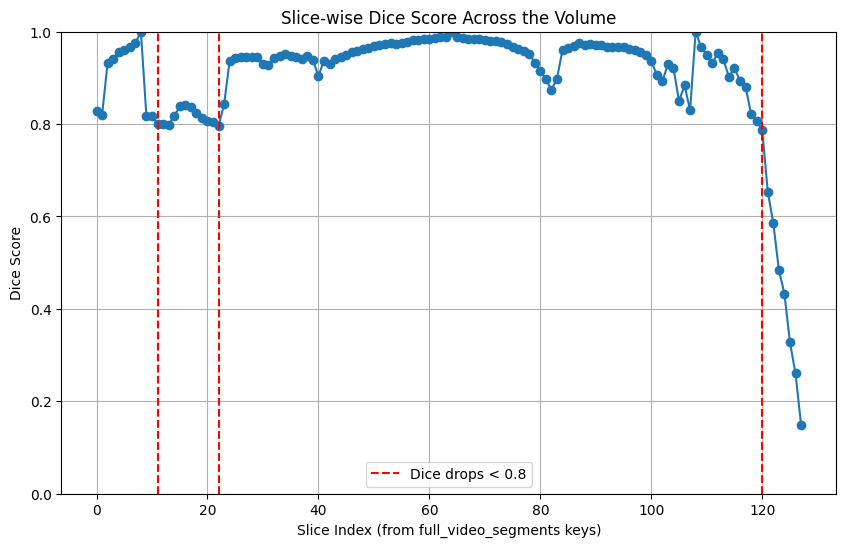

In [15]:
# Cell 14 (Updated: Slice-wise Dice Visualization with vertical lines marking transitions below 0.8)

# Use sorted frame indices from the full_video_segments dictionary.
sorted_frame_indices = sorted(full_video_segments.keys())

# Determine a target size from the first ground truth mask.
first_gt = np.load(os.path.join(video_dir, frame_names[sorted_frame_indices[0]].replace(".jpg", ".npy")))
target_size = (first_gt.shape[1], first_gt.shape[0])  # (width, height)

# Build lists of resized prediction and ground truth masks.
pred_masks = []
gt_masks = []

for k in sorted_frame_indices:
    pred_mask = safe_prepare_mask(full_video_segments[k], target_size)
    pred_masks.append(pred_mask)
    
    gt_mask = np.load(os.path.join(video_dir, frame_names[k].replace(".jpg", ".npy")))
    gt_mask_resized = safe_prepare_mask(gt_mask, target_size)
    gt_masks.append(gt_mask_resized)

# Convert lists to arrays; resulting shape will be (N, H, W)
video_seg_3d_array = np.stack(pred_masks, axis=0)
gt_3d_array = np.stack(gt_masks, axis=0)

def compute_slice_dice(pred, gt):
    """
    Compute the Dice score between two binary masks (2D arrays).
    If both masks are empty, returns 1.0.
    """
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    if np.sum(pred) == 0 and np.sum(gt) == 0:
        return 1.0
    return 2.0 * np.sum(np.logical_and(pred, gt)) / (np.sum(pred) + np.sum(gt))

# Compute the Dice score for each slice.
slice_dices = []
for i in range(video_seg_3d_array.shape[0]):
    d = compute_slice_dice(video_seg_3d_array[i], gt_3d_array[i])
    slice_dices.append(d)

# Find the slice indices where the Dice score starts going below 0.8.
vline_indices = []
for i in range(1, len(slice_dices)):
    if slice_dices[i] < 0.8 and slice_dices[i-1] >= 0.8:
        vline_indices.append(sorted_frame_indices[i])

# Plot the slice-wise Dice scores vs. slice index.
plt.figure(figsize=(10, 6))
plt.plot(sorted_frame_indices, slice_dices, marker='o', linestyle='-')
for idx in vline_indices:
    plt.axvline(x=idx, color='r', linestyle='--', linewidth=1.5, label="Dice drops < 0.8" if idx == vline_indices[0] else "")
plt.xlabel("Slice Index (from full_video_segments keys)")
plt.ylabel("Dice Score")
plt.title("Slice-wise Dice Score Across the Volume")
plt.ylim(0, 1)
plt.grid(True)
if vline_indices:
    plt.legend()
plt.show()
